<a href="https://colab.research.google.com/github/ipeirotis/dealing_with_data/blob/master/06-Spatial_Data_and_Maps/Showing_Census_Variables_on_a_Map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install -y -qq libproj-dev proj-data proj-bin libgdal-dev libspatialindex-dev  libgeos-dev

!pip uninstall -y  shapely
!pip install shapely --no-binary shapely

!pip install pyshp six cartopy geopandas fiona pyproj descartes pysal rtree pykdtree pyepsg pillow OWSLib geoplot

!pip3 install -U CensusData 

In [62]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import pandas as pd
import numpy as np
import geopandas as gpd
import censusdata
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.6.2-CAPI-1.10.2 4d2925d6) is incompatible with the GEOS version PyGEOS was compiled with (3.10.0-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


## Setup

In [11]:
STATEFP = "36"  # New York State
COUNTYFP = "061"  # Manhattan
YEAR = 2019

## Download Tract Shapefile for State and Limit Tracts to County of Interest

In [ ]:
# Download the census tracts shapes from US Census
# We download from the TIGER shapefiles repository


# Download the boundaries of tracts
filename = f"tl_{YEAR}_{STATEFP}_tract.zip"
!mkdir -p maps
!curl -s https://www2.census.gov/geo/tiger/TIGER$YEAR/TRACT/$filename -o maps/$filename
!cd maps && unzip -o $filename
shapefile = f"maps/{filename[:-4]}.shp"
geo_df = gpd.GeoDataFrame.from_file(shapefile)
# Keep only the data for the county of interest
geo_df = geo_df.query(f"COUNTYFP == '{COUNTYFP}'")

# We download the water areas, to avoid including water areas in our maps
water_filename = f"tl_{YEAR}_{STATEFP+COUNTYFP}_areawater.zip"
!curl -s https://www2.census.gov/geo/tiger/TIGER$YEAR/AREAWATER/$water_filename  -o maps/$water_filename
!cd maps && unzip -o $water_filename
water_shapefile = f"maps/{water_filename[:-4]}.shp"
water_geodf = gpd.GeoDataFrame.from_file(water_shapefile)

# Remove water areas from the tracts
geo_df = gpd.overlay(geo_df, water_geodf, how="difference")


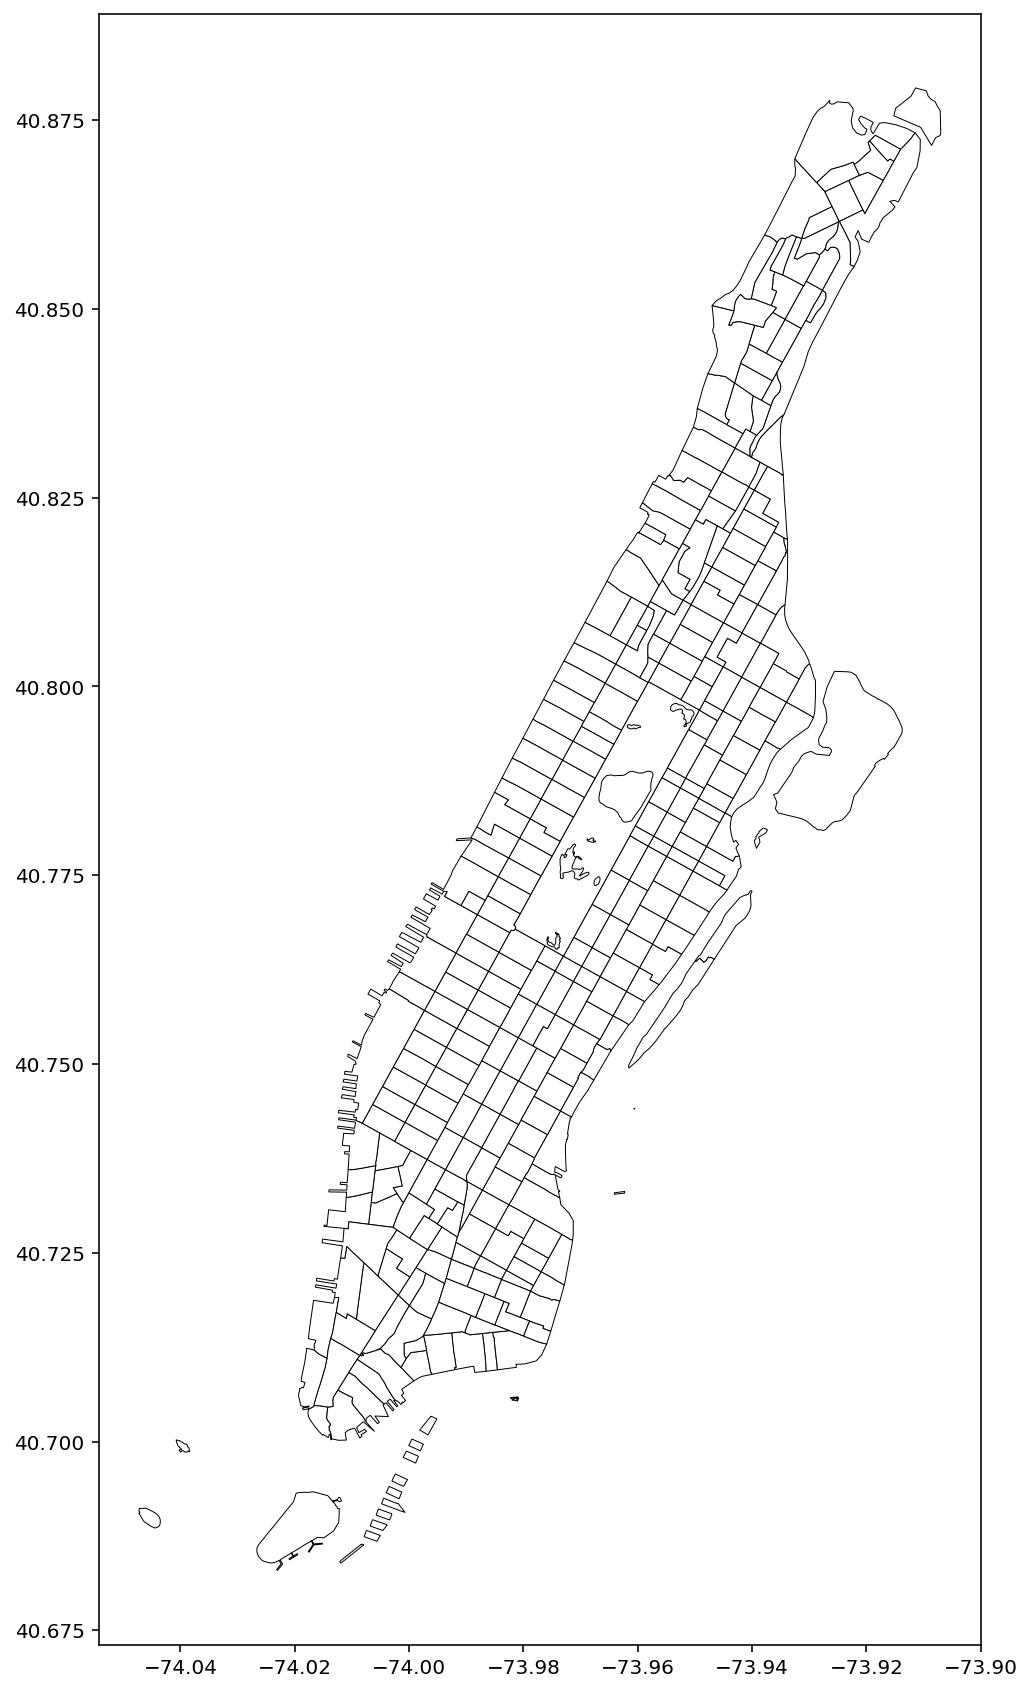

In [24]:
# Plot the tract boundaries
geo_df.plot(
    figsize=(15, 15),
    color="white",
    edgecolor="black",
    linewidth=0.5,
    zorder=0,
    facecolor="white",
)

## Access Census Details for All Tracts in County

In [18]:
# We specify what locations we want the data for
# We will retrieve information for all the tracts in 
# the state (STATEFP) and county (COUNTYFP) that we
# specified earlier
census_location_query = [("state", STATEFP), ("county", COUNTYFP), ("tract", "*")]

# We specify the attribute(s) that we want to retrieve
census_attr = "B07001_001E"
friendly_name = "Total_Population"
census_attribute_query = [census_attr]

# Download data for the variable of interest from census
df = censusdata.download(
    "acs5", # we use the ACS survey, 5-year data
    YEAR, # we use the data from the 2019 survey
    censusdata.censusgeo(census_location_query),
    census_attribute_query,
)
df = df.rename({census_attr: friendly_name}, axis="columns")

# To visualize the variable, we will assign a percentile score to
# each tract (otherwise outlier values make it hard to differentiate) 
df[friendly_name + "_percentile"] = df[friendly_name].rank(pct=True)

# Replace the index of the dataframe with state, county, and tract values
df = df.reset_index().rename({"index": "tract_info"}, axis="columns")
df["state"] = [v.geo[0][1] for v in df.tract_info.values]
df["county"] = [v.geo[1][1] for v in df.tract_info.values]
df["tract"] = [v.geo[2][1] for v in df.tract_info.values]
df = df.drop("tract_info", axis="columns")

df

,Total_Population,Total_Population_percentile,state,county,tract
0,5982,0.552083,36,061,025500
1,3325,0.253472,36,061,022200
2,1535,0.090278,36,061,001001
3,8470,0.826389,36,061,000700
4,2042,0.125000,36,061,010300
...,...,...,...,...,...
283,6236,0.593750,36,061,021800
284,7915,0.788194,36,061,028300
285,12059,0.972222,36,061,029100
286,8161,0.798611,36,061,029500


## Visualizing Census Variables on a Map

### Population per tract

In [ ]:
aux_df = pd.merge(
    geo_df,
    df,
    left_on=["STATEFP", "COUNTYFP", "TRACTCE"],
    right_on=["state", "county", "tract"],
)


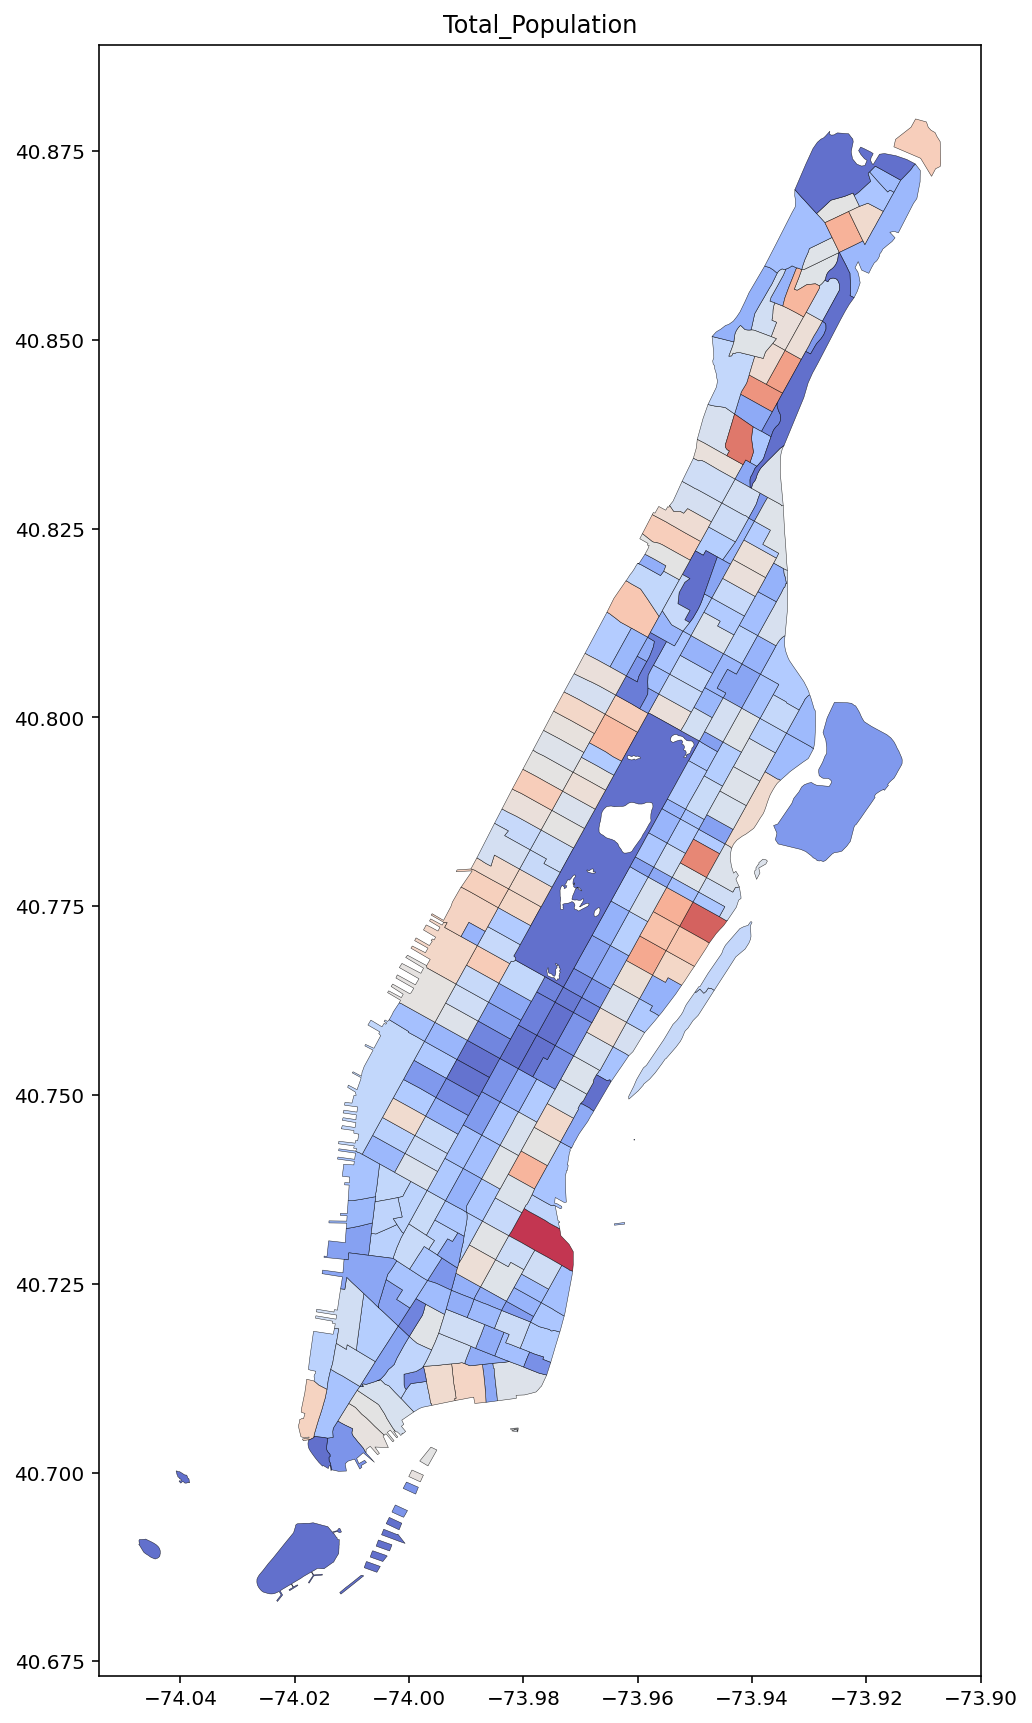

In [46]:
# Plotting the raw population values
# Notice that due to a few outlier values, most
# of the map looks
ax = aux_df.plot(
    column=friendly_name,
    linewidth=0.25,
    edgecolor="Black",
    figsize=(15, 15),
    cmap="coolwarm",
    alpha=0.8,
)
ax.set_title(friendly_name)
pass # do not print the title in the output

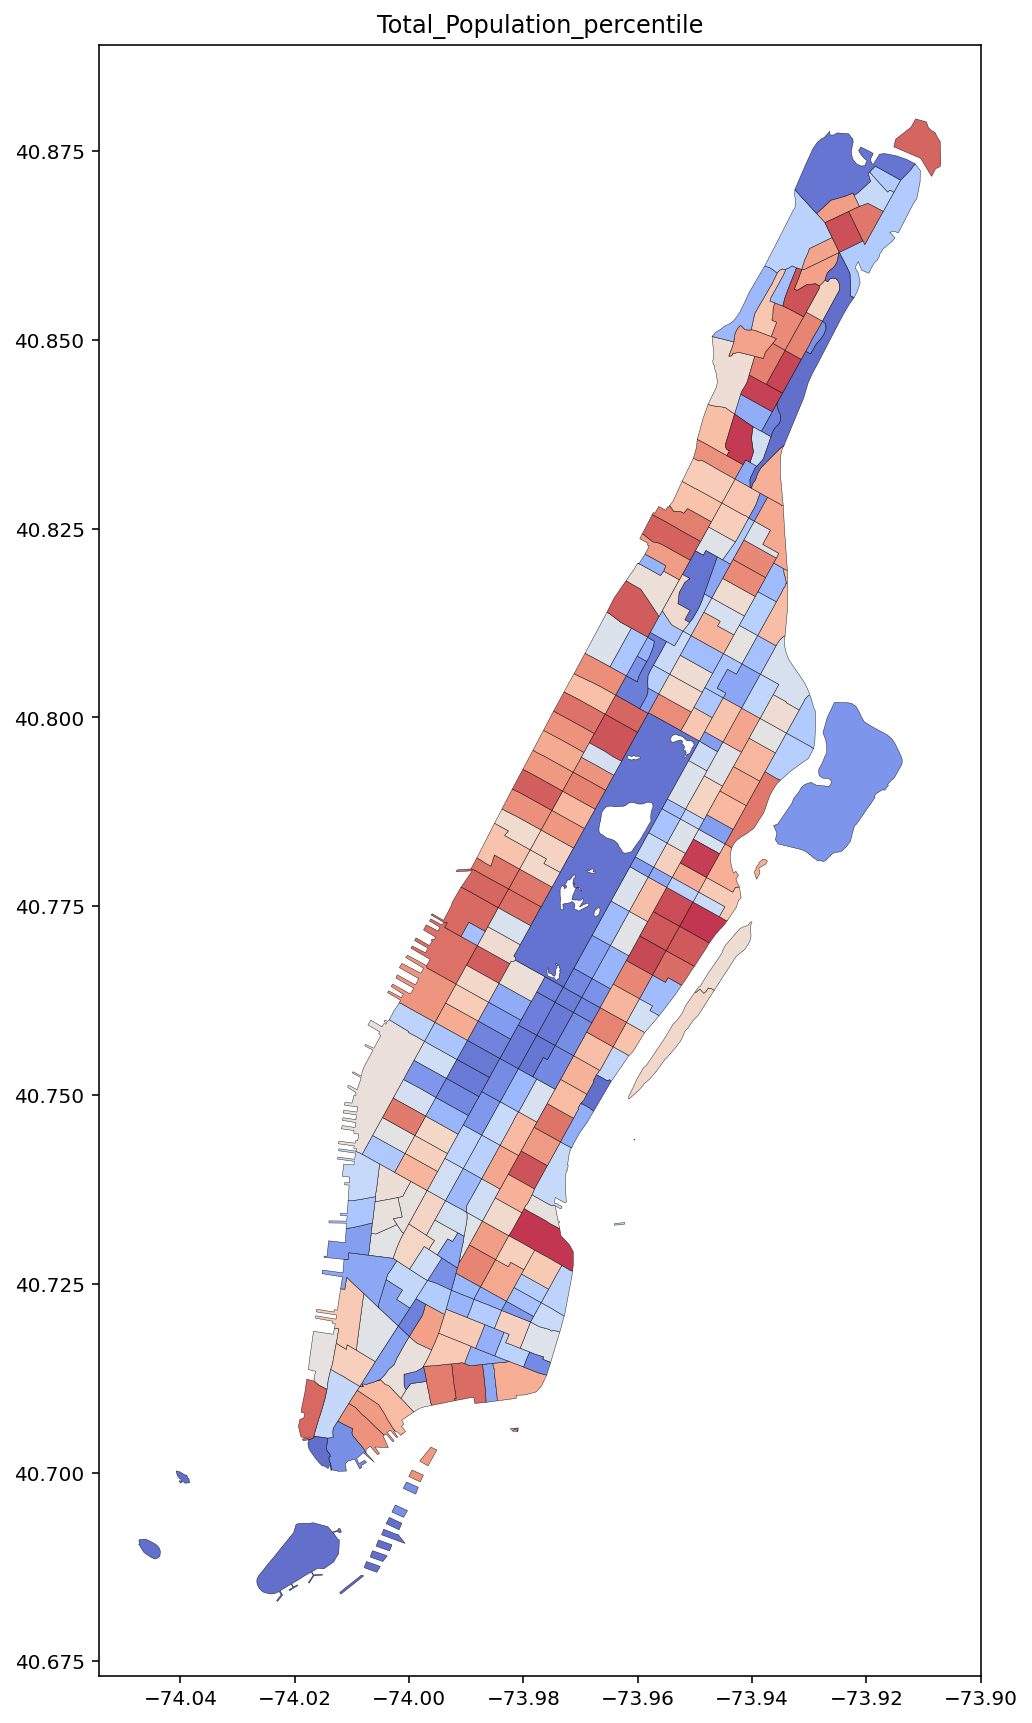

In [47]:
# By using the percentile values instead (which are normalized and uniform)
# the colors associated with each tract are now more informative (at the
# expense of not highlighting the outliers)
ax = aux_df.plot(
    column=friendly_name + "_percentile",
    linewidth=0.25,
    edgecolor="Black",
    figsize=(15, 15),
    cmap="coolwarm",
    alpha=0.8,
)
ax.set_title(friendly_name + "_percentile")
pass # do not print the title in the output

### Population density per tract

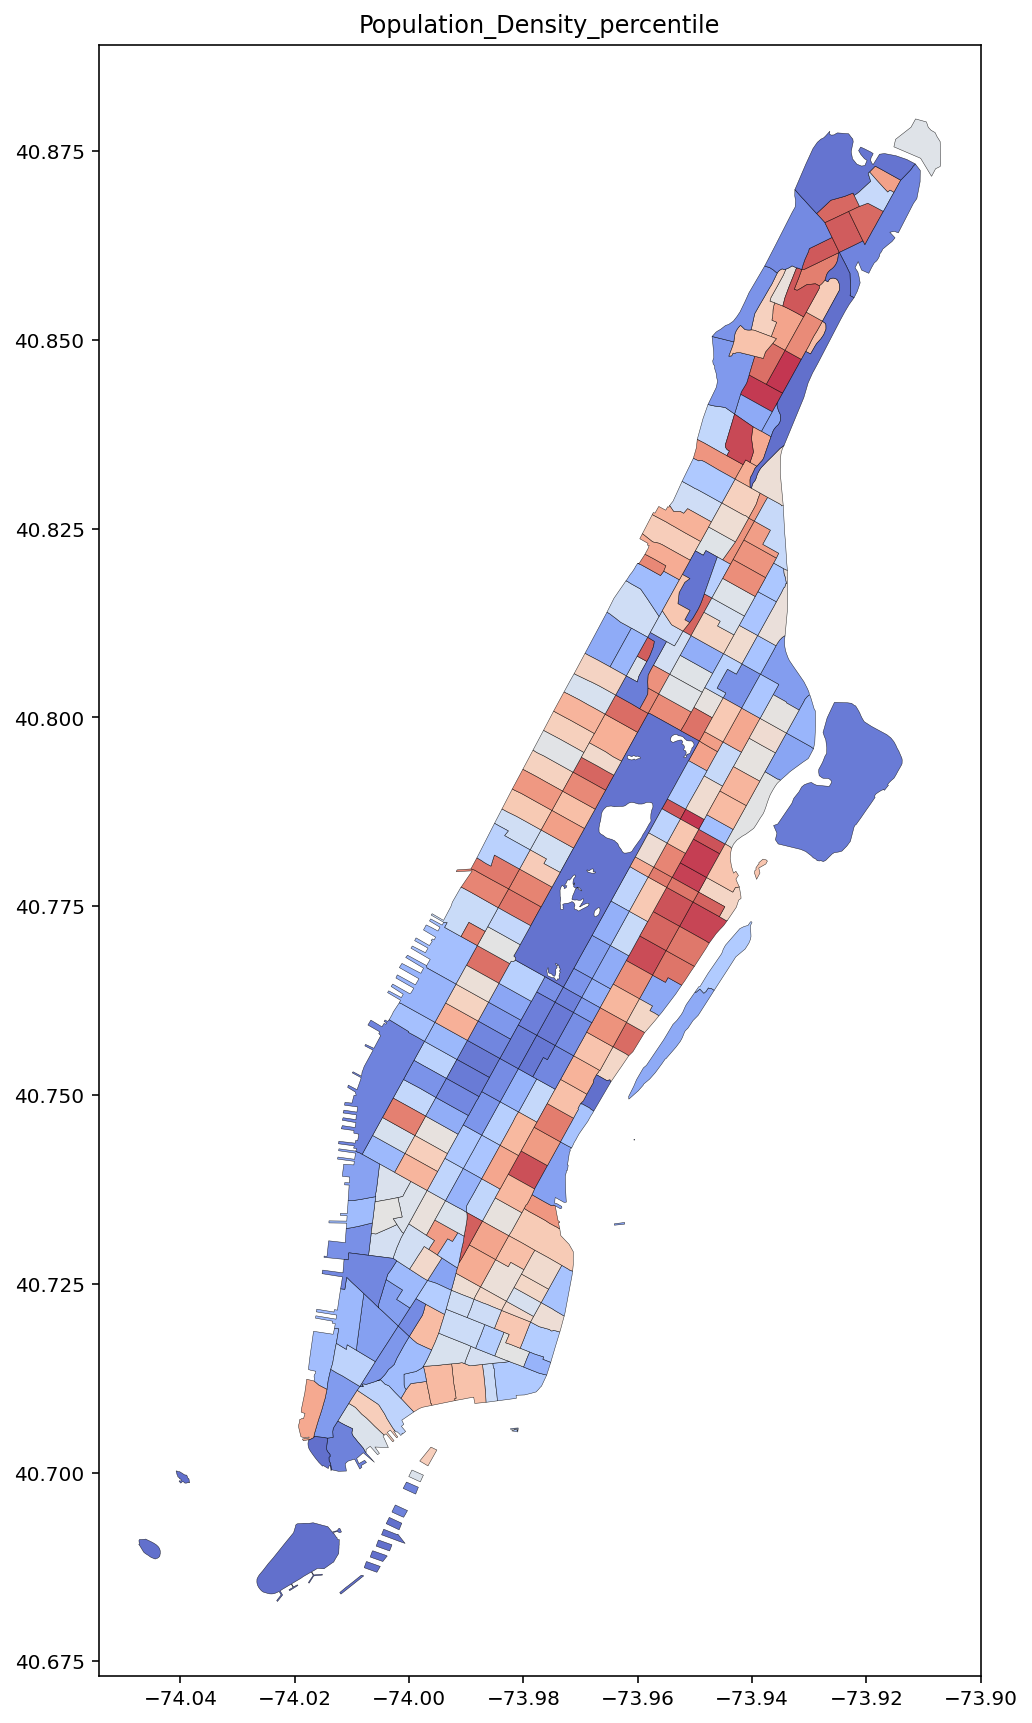

In [50]:
# Using the land area of each tract, we can calculate the population density
# to account for the different sizes of the tracts
aux_df['Population_Density'] = aux_df['Total_Population']/aux_df['ALAND']
aux_df['Population_Density_percentile'] = aux_df['Population_Density'].rank(pct=True)

ax = aux_df.plot(
    column="Population_Density_percentile",
    linewidth=0.25,
    edgecolor="Black",
    figsize=(15, 15),
    cmap="coolwarm",
    alpha=0.8,
)

ax.set_title("Population_Density_percentile")
pass

## Putting multiple maps on a plot, plus Manhattan neighborhoods

In [31]:
# Dataset from NYC Open Data: https://data.cityofnewyork.us/City-Government/Neighborhood-Tabulation-Areas/cpf4-rkhq
nyc_geourl = "https://data.cityofnewyork.us/api/geospatial/cpf4-rkhq?method=export&format=GeoJSON"
nyc_neighborhoods = gpd.GeoDataFrame.from_file(nyc_geourl)
manhattan = nyc_neighborhoods[nyc_neighborhoods.county_fips == "061"]

In [51]:
def plot_variable(df, variable_name, percentile, ax):

  if percentile: suffix = "_percentile" 
  else:  suffix = "" 
  
    # Plot the variable of interest
  ax = df.plot(
      column=variable_name + suffix,
      linewidth=0.5,
      edgecolor="Black",
      cmap="coolwarm",
      alpha=0.6,
      ax = ax
  )
  ax.set_title(variable_name + suffix)

  # For aesthetics, we plot the NYC neighborhoods on top
  manhattan.plot(
      color="white",
      edgecolor="black",
      linewidth=2,
      zorder=0,
      facecolor="white",
      ax=ax,
  )
  return ax

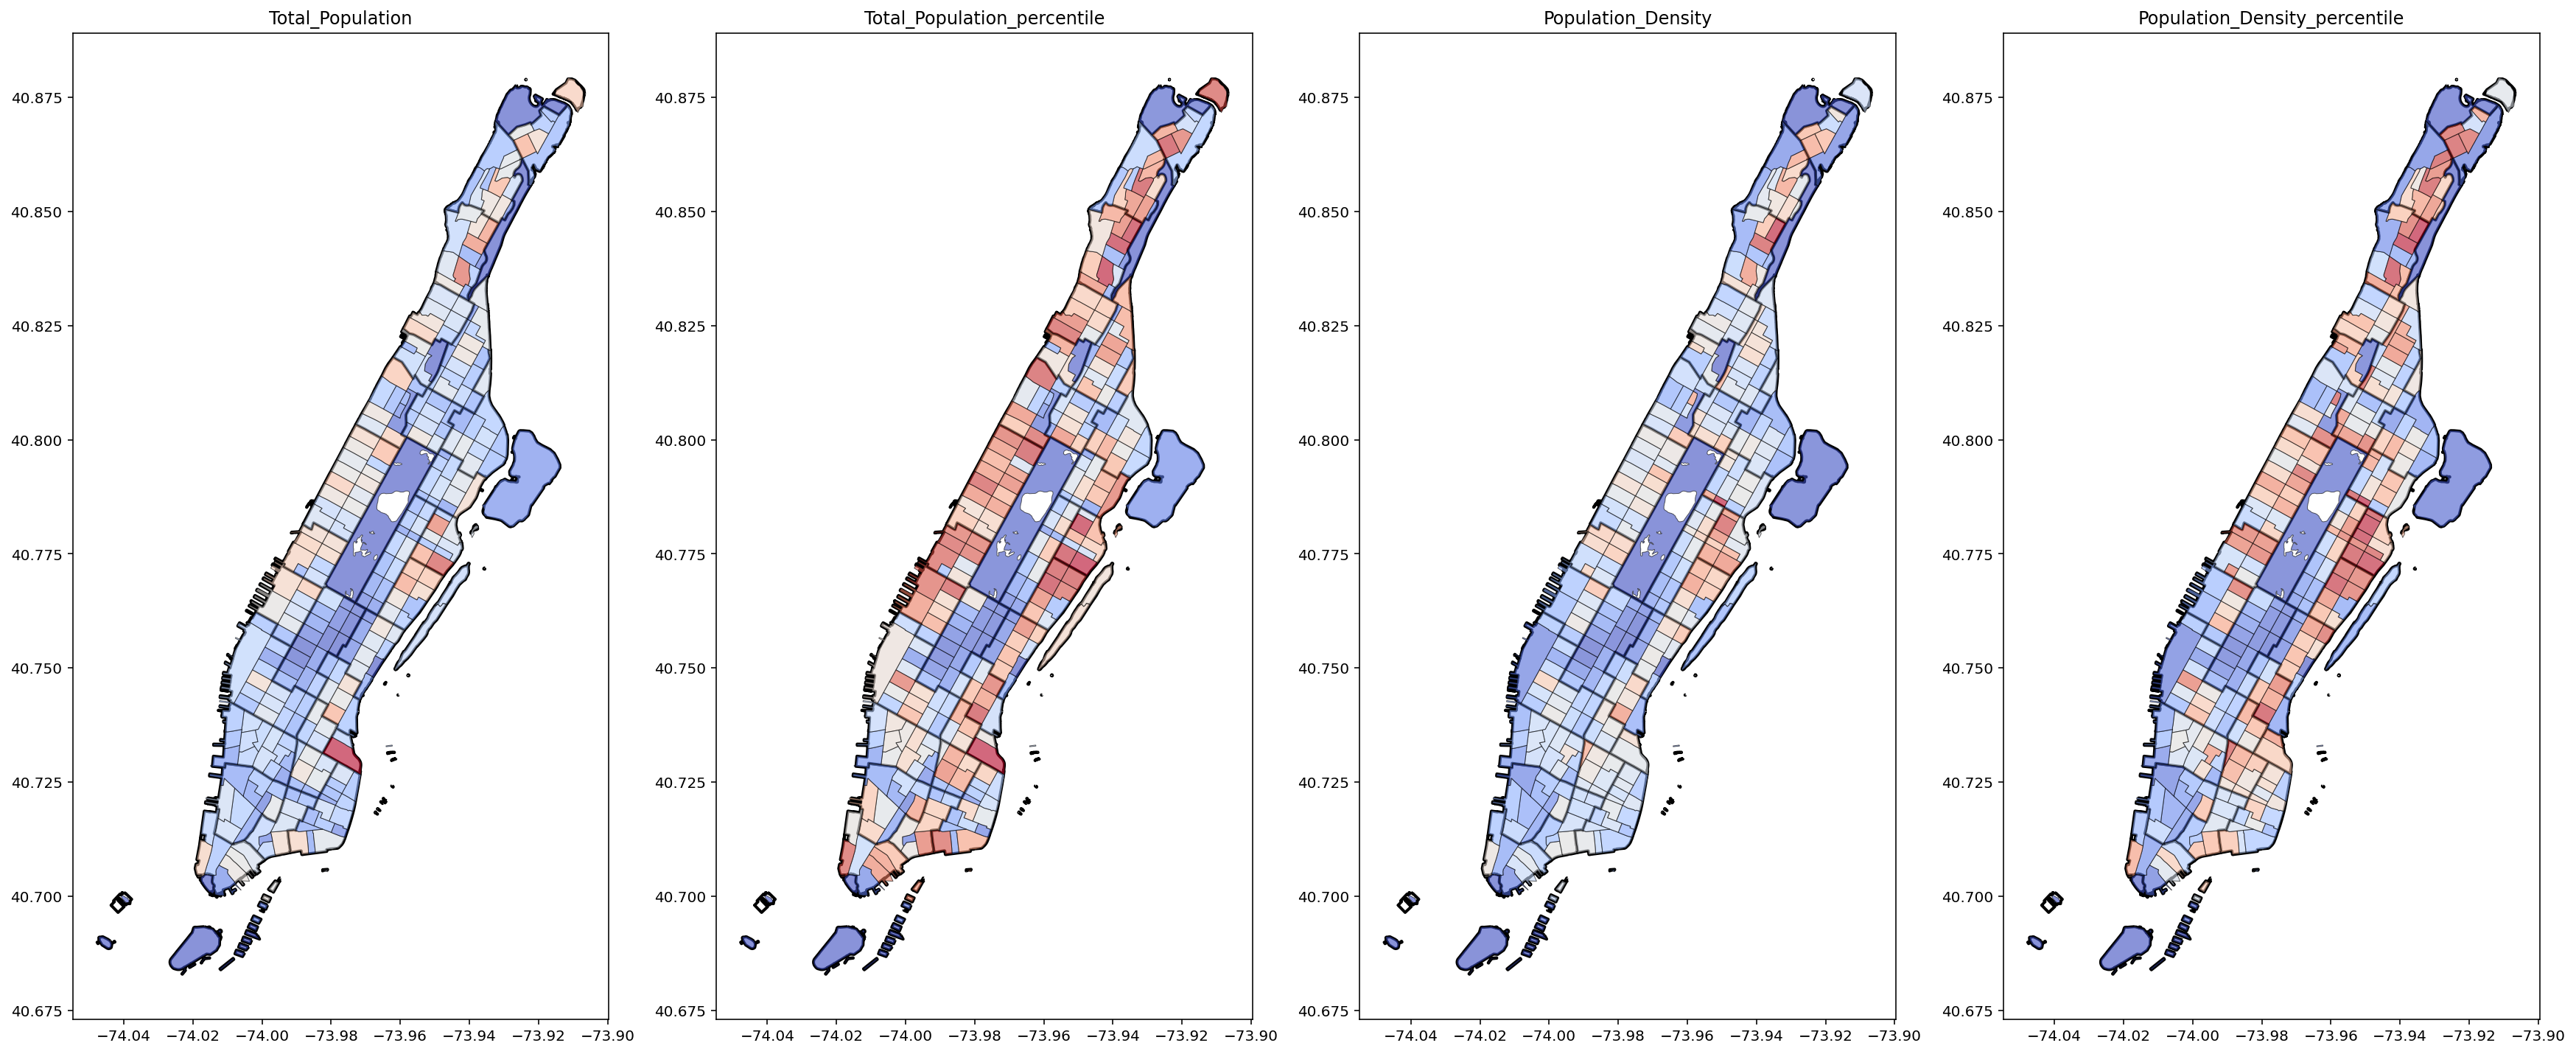

In [59]:

# Create a figure, with a 1x4 grid. 
# The "ax" is a 1-dimensional array with 4 elements
fig, ax = plt.subplots(nrows=1, ncols=4, figsize =(30,15))

# We now create one plot for each of the 4 "axes" and put the plot in the 
# corresponding ax
plot_variable(aux_df, "Total_Population", percentile=False, ax = ax[0])
plot_variable(aux_df, "Total_Population", percentile=True, ax = ax[1])
plot_variable(aux_df, "Population_Density", percentile=False, ax = ax[2])
plot_variable(aux_df, "Population_Density", percentile=True, ax = ax[3])



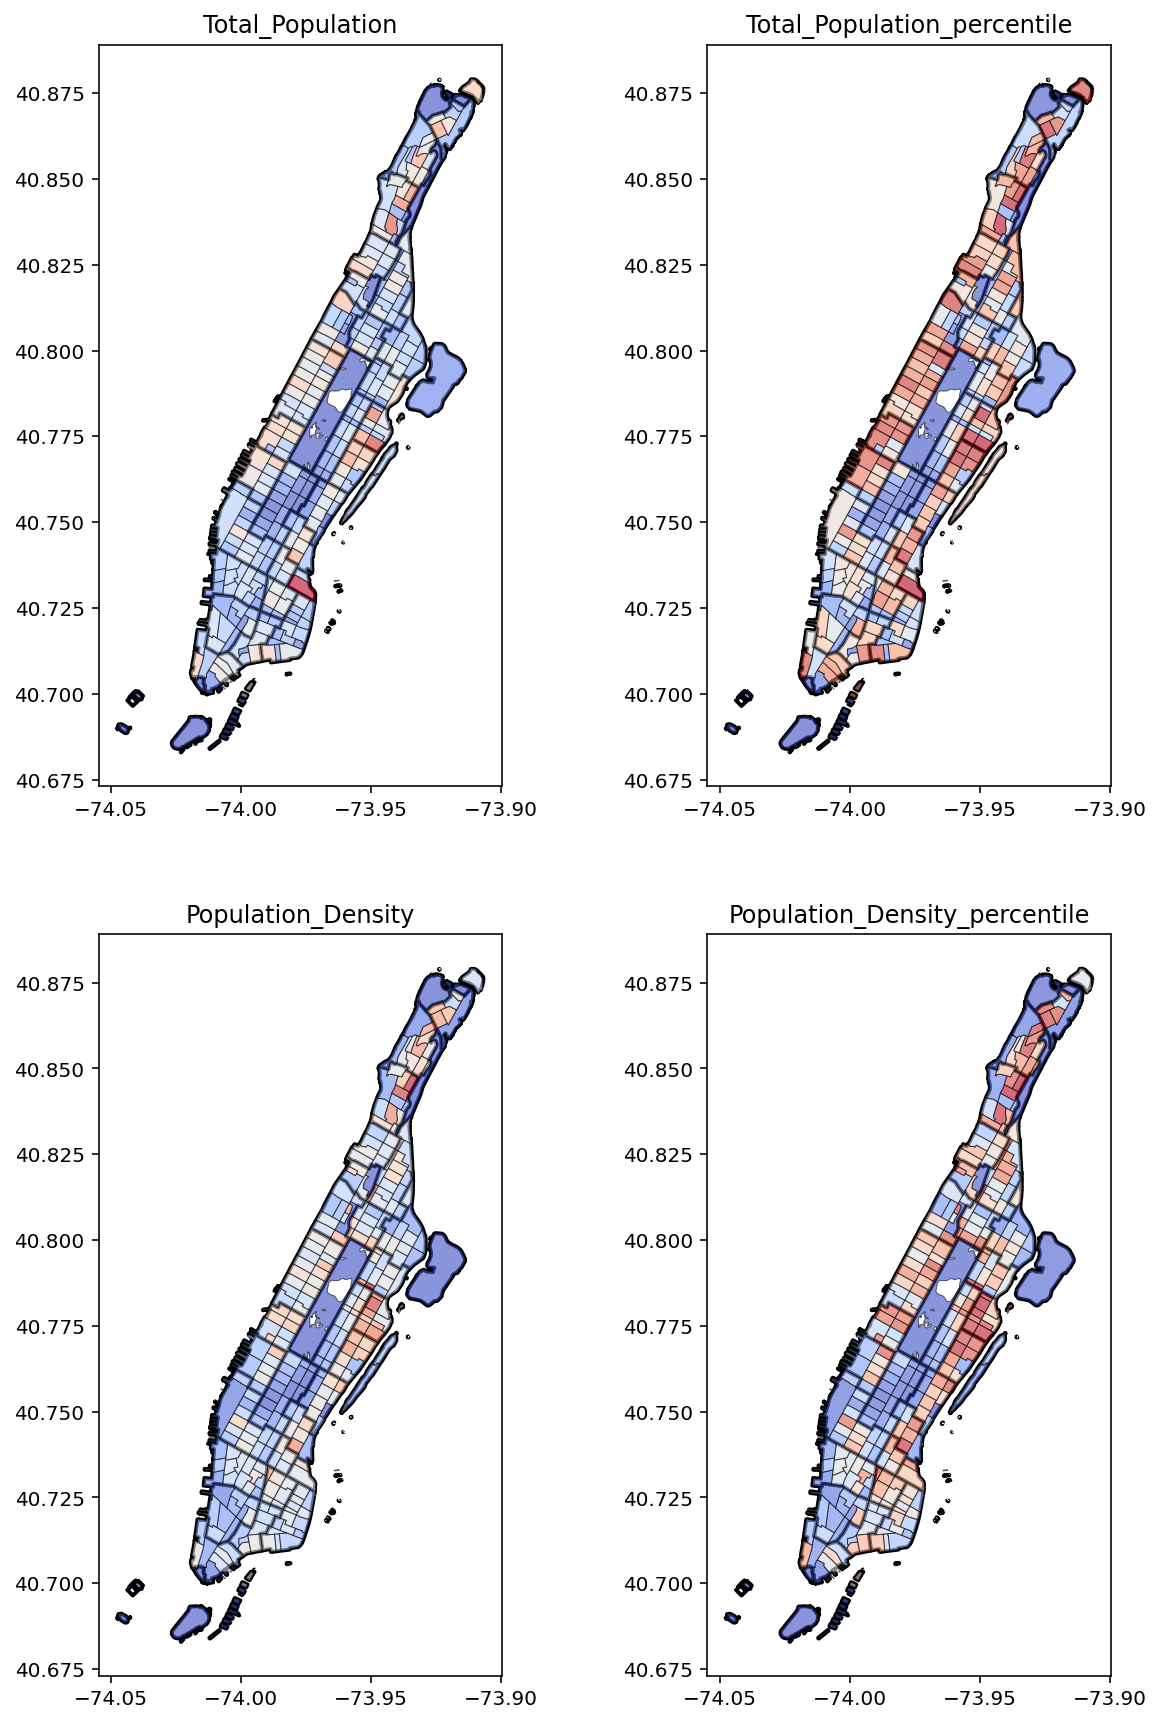

In [61]:

# Repeat, but with two rows and two columns
# Create a figure, with a 2x2 grid. The "ax" is a 2-dimensional array
fig, ax = plt.subplots(nrows=2, ncols=2, figsize =(10,15))

# We now create one plot for each of the 4 "axes" and put the plot in the 
# corresponding ax
plot_variable(aux_df, "Total_Population", percentile=False, ax = ax[0][0])
plot_variable(aux_df, "Total_Population", percentile=True, ax = ax[0][1])
plot_variable(aux_df, "Population_Density", percentile=False, ax = ax[1][0])
plot_variable(aux_df, "Population_Density", percentile=True, ax = ax[1][1])